# Exact solution used in MES runs


We would like to MES the operation (in a cylindrical geometry)

$$
\nabla \cdot \left(\mathbf{u}_E\cdot\nabla \left[\frac{\nabla_\perp \phi}{B}n\right]\right)
$$

As we have a homogenenous $B$-field, we have normalized it out, and remain with

$$
\nabla \cdot \left(\mathbf{u}_E\cdot\nabla\left[n\nabla_\perp \phi\right]\right)
$$

In [1]:
%matplotlib notebook

from sympy import init_printing
from sympy import S
from sympy import sin, cos, tanh, exp, pi, sqrt

from boutdata.mms import x, y, z, t

import os, sys
# If we add to sys.path, then it must be an absolute path
common_dir = os.path.abspath('./../../../')
# Sys path is a list of system paths
sys.path.append(common_dir)
from CELMAPy.MES import get_metric, make_plot, BOUT_print

init_printing()

In [2]:
def DDX(f):
    return f.diff(x, 1)

def D2DX2(f):
    return f.diff(x, 2)

def D3DX3(f):
    return f.diff(x, 3)

def DDZ(f):
    return f.diff(z, 1)

def D2DZ2(f):
    return f.diff(z, 2)

def D3DZ3(f):
    return f.diff(z, 3)

## Initialize

In [3]:
folder = '../twoGaussians/'
metric = get_metric()

## Define the variables

In [4]:
# Initialization
the_vars = {}

### Define functions

One can show that in cylindrical geometry

$$\nabla \cdot \left(\mathbf{u}_E\cdot\nabla\left[n\nabla_\perp \phi\right]\right) = 
(
                  n(
                    - \partial_{x}\phi(
                          \partial_{xxz}\phi J^3
                        + \partial_{xz}\phi J^2
                        + \partial_{z}\phi J
                        + \partial_{zzz}\phi J)
                     + \partial_{z}\phi (
                           \partial_{xx}\phi J^2
                         + \partial_{xxx}\phi J^3
                         + \partial_{xzz}\phi J
                         - 2 \partial_{zz}\phi)
                     )
                - (\partial_{x}\phi^2)(
                      \partial_{xz}n J^3
                    + \partial_{z}n J^2
                                  )
                + (\partial_{z}\phi^2)(
                      \partial_{xz} n J
                    - \partial_{z} n
                                  )
                + \partial_{x}\phi(
                      \partial_{z}\phi (
                          \partial_{x}n J^2
                        + \partial_{xx}n J^3
                        - \partial_{zz}n J
                            )
                    - 2 \partial_{z} n (
                        \partial_{xx}\phi J^3
                        + \partial_{zz}\phi J
                              )
                        )
                + 2 \partial_{x}n \partial_{z}\phi (
                          \partial_{xx}\phi J^3
                        + \partial_{zz}\phi J
                                )
             )/J^4
$$

**NOTE**:

1. z must be periodic
2. The field $f(\rho, \theta)$ must be of class infinity in $z=0$ and $z=2\pi$
3. The field $f(\rho, \theta)$ must be single valued when $\rho\to0$
4. The field $f(\rho, \theta)$ must be continuous in the $\rho$ direction with $f(\rho, \theta + \pi)$
5. Eventual BC in $\rho$ must be satisfied

In [5]:
# We need Lx
from boututils.options import BOUTOptions
myOpts = BOUTOptions(folder)
Lx = eval(myOpts.geom['Lx'])

In [6]:
# Two gaussians

# The skew sinus
# In cartesian coordinates we would like a sinus with with a wave-vector in the direction
# 45 degrees with respect to the first quadrant. This can be achieved with a wave vector
# k = [1/sqrt(2), 1/sqrt(2)]
# sin((1/sqrt(2))*(x + y))
# We would like 2 nodes, so we may write
# sin((1/sqrt(2))*(x + y)*(2*pi/(2*Lx)))
# Rewriting this to cylindrical coordinates, gives
# sin((1/sqrt(2))*(x*(cos(z)+sin(z)))*(2*pi/(2*Lx)))

# The gaussian
# In cartesian coordinates we would like
# f = exp(-(1/(2*w^2))*((x-x0)^2 + (y-y0)^2))
# In cylindrical coordinates, this translates to
# f = exp(-(1/(2*w^2))*(x^2 + y^2 + x0^2 + y0^2 - 2*(x*x0+y*y0) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta)*cos(theta0)+sin(theta)*sin(theta0)) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta - theta0)) ))

# A parabola
# In cartesian coordinates, we have
# ((x-x0)/Lx)^2
# Chosing this function to have a zero value at the edge yields in cylindrical coordinates
# ((x*cos(z)+Lx)/(2*Lx))^2


w = 0.8*Lx
rho0 = 0.3*Lx
theta0 = 5*pi/4
the_vars['n'] = sin((1/sqrt(2))*(x*(cos(z)+sin(z)))*(2*pi/(2*Lx)))*\
                  exp(-(1/(2*w**2))*(x**2 + rho0**2 - 2*x*rho0*(cos(z - theta0)) ))*\
                  ((x*cos(z)+Lx)/(2*Lx))**2

# The gaussian

# In cartesian coordinates we would like
# f = exp(-(1/(2*w^2))*((x-x0)^2 + (y-y0)^2))
# In cylindrical coordinates, this translates to
# f = exp(-(1/(2*w^2))*(x^2 + y^2 + x0^2 + y0^2 - 2*(x*x0+y*y0) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta)*cos(theta0)+sin(theta)*sin(theta0)) ))
#   = exp(-(1/(2*w^2))*(rho^2 + rho0^2 - 2*rho*rho0*(cos(theta - theta0)) ))

w = 0.5*Lx
rho0 = 0.2*Lx
theta0 = pi
the_vars['phi'] = exp(-(1/(2*w**2))*(x**2 + rho0**2 - 2*x*rho0*(cos(z - theta0)) ))

Calculate the solution

In [7]:
# Calculate the derivatives
phi_x   = DDX      (the_vars['phi'])
phi_xx  = D2DX2    (the_vars['phi'])
phi_xxx = D3DX3    (the_vars['phi'])
phi_z   = DDZ      (the_vars['phi'])
phi_zz  = D2DZ2    (the_vars['phi'])
phi_zzz = D3DZ3    (the_vars['phi'])
phi_xz  = DDX(DDZ  (the_vars['phi']))
phi_xxz = D2DX2(DDZ(the_vars['phi']))
phi_xzz = DDX(D2DZ2(the_vars['phi']))
n_x     = DDX      (the_vars['n'])
n_xx    = D2DX2    (the_vars['n'])
n_z     = DDZ      (the_vars['n'])
n_zz    = D2DZ2    (the_vars['n'])
n_xz    = DDX(DDZ  (the_vars['n']))

# Auxiliary variables
n       = the_vars['n']
x       = metric.J
x2      = metric.J**2
x3      = metric.J**3
x4      = metric.J**4

# Solution
the_vars['S'] = (n*(
                    - phi_x*(
                          phi_xxz*x3
                        + phi_xz*x2
                        + phi_z*x
                        + phi_zzz*x)
                     + phi_z*(
                           phi_xx*x2
                         + phi_xxx*x3
                         + phi_xzz*x
                         - 2*phi_zz)
                     )
                - (phi_x**(2))*(
                      n_xz*x3
                    + n_z*x2
                                  )
                + (phi_z**(2))*(
                      n_xz*x
                    - n_z
                                  )
                + phi_x*(
                      phi_z*(
                          n_x*x2
                        + n_xx*x3
                        - n_zz*x
                            )
                    - 2.0*n_z*(
                        phi_xx*x3
                        + phi_zz*x
                              )
                        )
                + 2.0*n_x*phi_z*(
                          phi_xx*x3
                        + phi_zz*x
                                )
             )/x4

## Plot

<IPython.core.display.Javascript object>


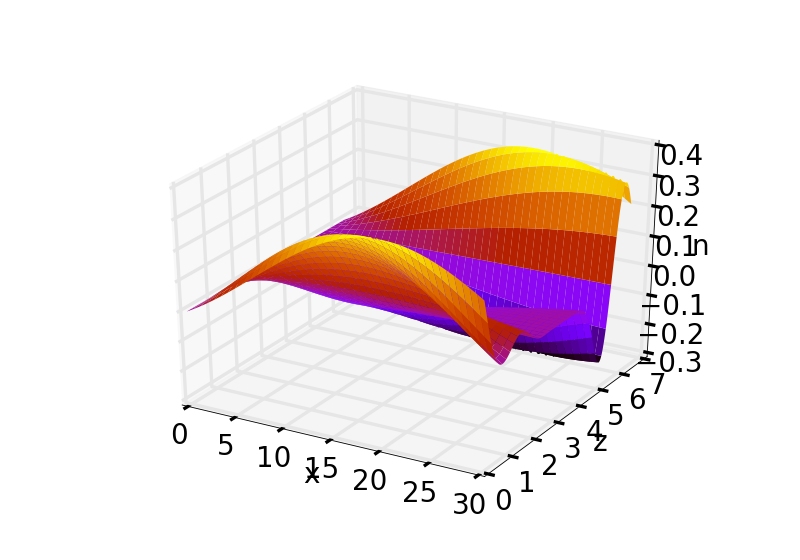

<IPython.core.display.Javascript object>


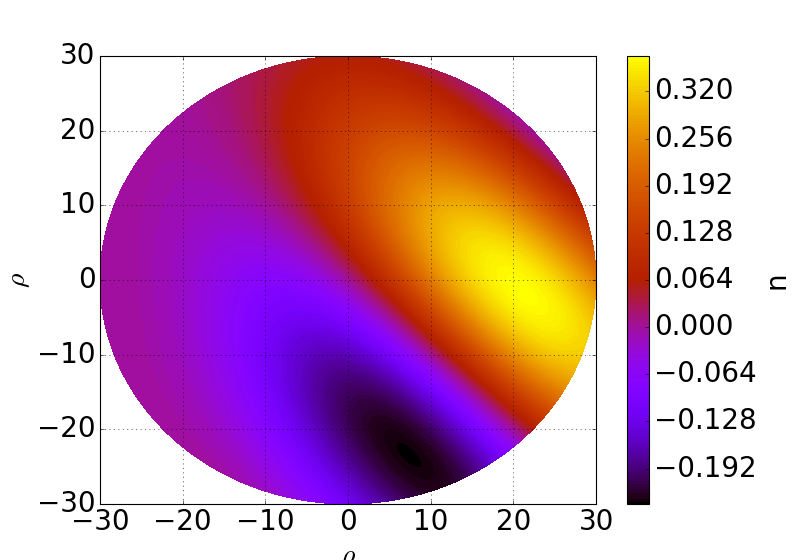

<IPython.core.display.Javascript object>


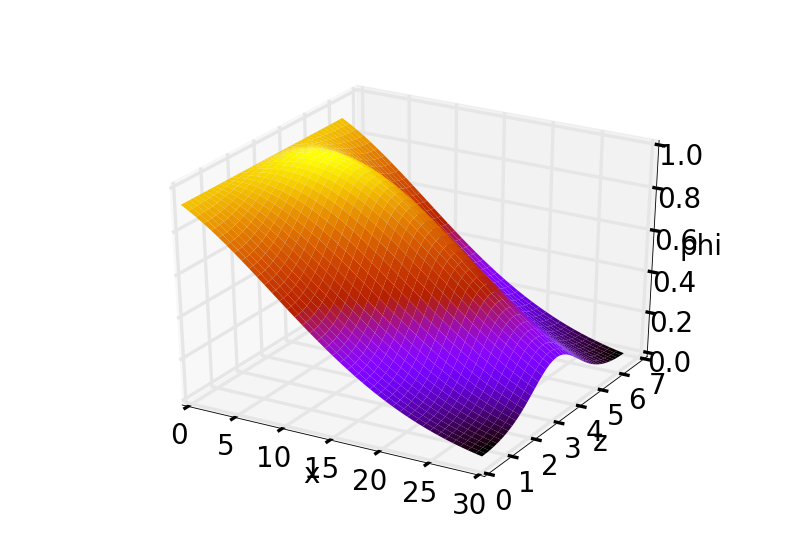

<IPython.core.display.Javascript object>


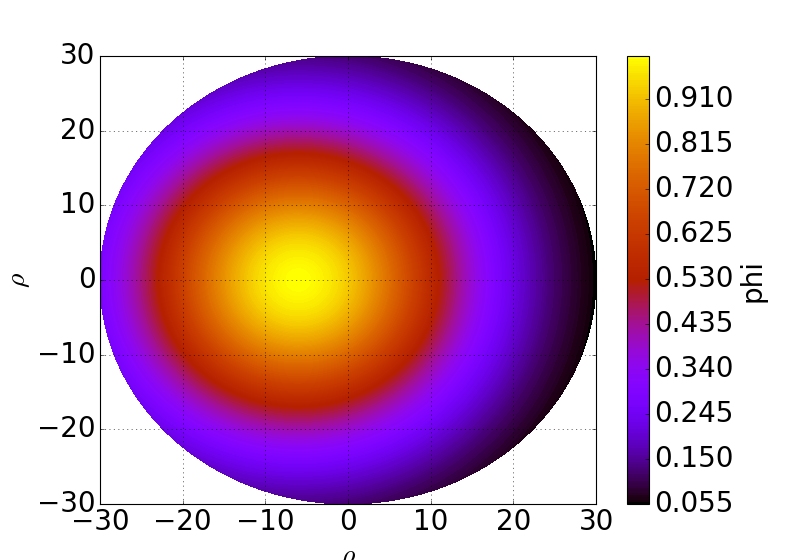

<IPython.core.display.Javascript object>


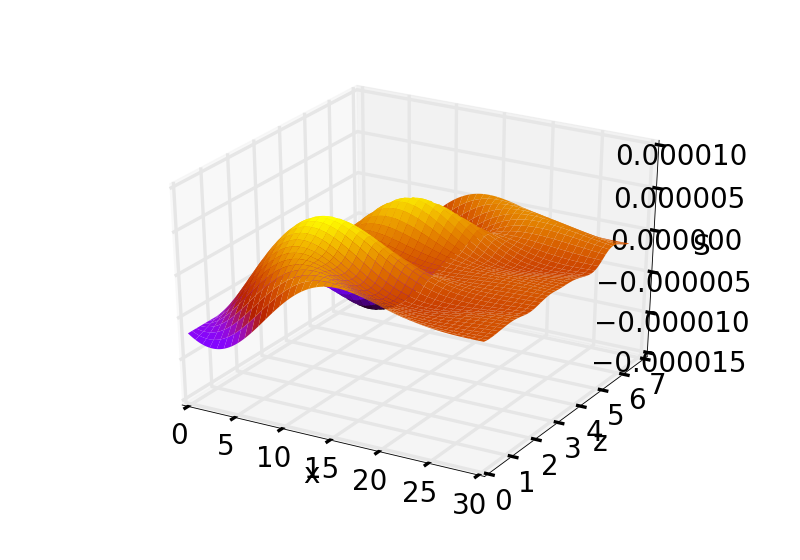

<IPython.core.display.Javascript object>


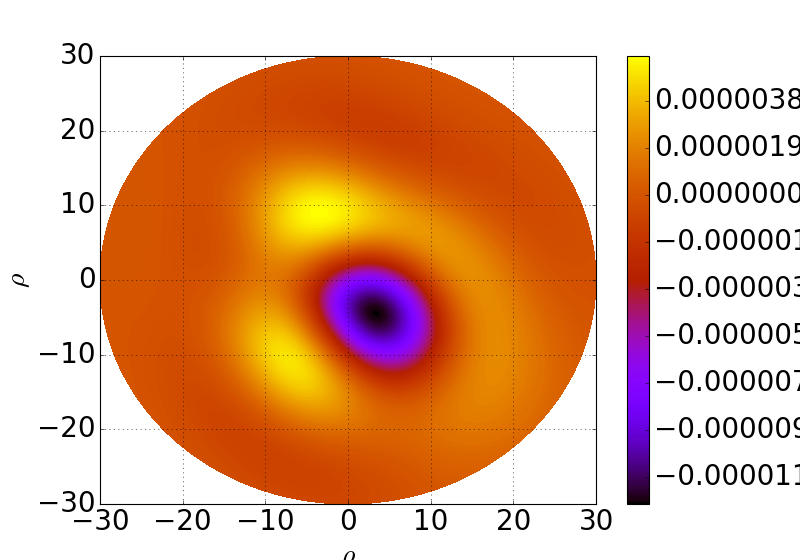

In [8]:
make_plot(folder=folder, the_vars=the_vars, plot2d=True, include_aux=False)

## Print the variables in BOUT++ format

In [9]:
BOUT_print(the_vars, rational=False)


[n]
0.932102492359528*(geom:xl*cos(z)/60 + 1/2)^2*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*sin(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60)

[phi]
0.923116346386636*exp(-0.00222222222222222*geom:xl^2 - 0.0266666666666667*geom:xl*cos(z))

[S]
(0.000605968916598195*geom:xl^2*(-0.0155350415393255*sqrt(2)*pi*geom:xl*(geom:xl*cos(z)/60 + 1/2)^2*(-sin(z) + cos(z))*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*cos(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60) + 0.0145641014431176*geom:xl*(geom:xl*cos(z)/60 + 1/2)^2*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*sin(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60)*cos(z + pi/4) + 0.0310700830786509*geom:xl*(geom:xl*cos(z)/60 + 1/2)*exp(-0.000868055555555556*geom:xl^2 - 0.015625*geom:xl*sin(z + pi/4))*sin(z)*sin(sqrt(2)*pi*geom:xl*(sin(z) + cos(z))/60) + geom:xl*(0.0155350415393255*sqrt(2)*pi*geom:xl*(-0.00173611111111111*geom:xl - 0.015625*sin(z + pi/4))*(geom:xl*cos(z)/60 + 1/2)^2*(-